In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import torch
import matplotlib.pyplot as plt
from dataio.transformation.imageTransformations import RandomFlipTransform, RandomElasticTransform, RandomAffineTransform, RandomNoiseTransform
from dataio.transformation.imageTransformations import StandardizeImage
from gsprep.visual_tools.visual import display, display_4D

In [2]:
dataset_path = "D:/GitHub/StrokeLesionPredict-BIO503/data/working_data/pct_unet_all_2016_2017/rescaled_data_set.npz"
channel = 0
subj_id = None
subj = 0
ids = np.load(dataset_path, allow_pickle=True)['ids']
if subj_id is not None:
    subj = np.argwhere(ids==subj_id)[0, 0]

raw_images = np.load(dataset_path, allow_pickle=True)['ct_inputs'][subj][..., 0:4].astype(np.float64)
try:
    raw_labels = np.load(dataset_path, allow_pickle=True)['ct_lesion_GT'][subj].astype(np.float64)
except:
    raw_labels = np.load(dataset_path, allow_pickle=True)['lesion_GT'][subj].astype(np.float64)
raw_mask = np.load(dataset_path, allow_pickle=True)['brain_masks'][subj]

raw_images.shape

(79, 95, 79, 4)

.

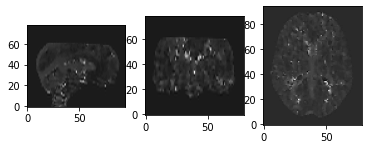

<module 'matplotlib.pyplot' from 'd:\\python\\anaconda3\\envs\\pctnet\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [3]:
display_4D(raw_images)

Image center:  39 47 39
Image center value:  5.7799998708069324


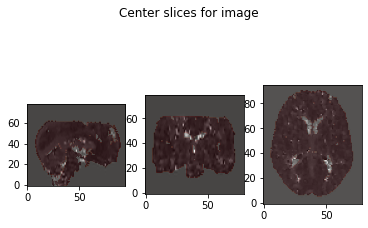

Image center:  39 47 39
Image center value:  93.09999791905284


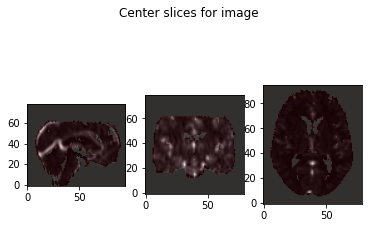

Image center:  39 47 39
Image center value:  8.509999809786677


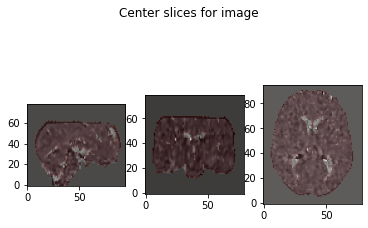

Image center:  39 47 39
Image center value:  12.669999716803432


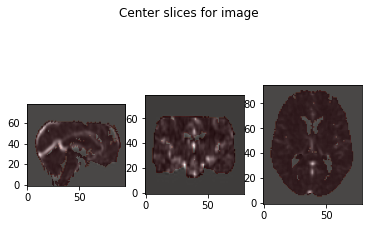

<module 'matplotlib.pyplot' from 'd:\\python\\anaconda3\\envs\\pctnet\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [4]:
display(raw_images[..., 0], raw_mask)
display(raw_images[..., 1], raw_mask)
display(raw_images[..., 2], raw_mask)
display(raw_images[..., 3], raw_mask)

In [5]:
# images, labels = torch.from_numpy(np.expand_dims(raw_images, axis=-1)), \
#                  torch.from_numpy(np.expand_dims(raw_labels, axis=-1))
images, labels = torch.from_numpy(raw_images), \
                 torch.from_numpy(np.expand_dims(raw_labels, axis=-1))


seed = 7533
max_output_channels = 2
print(images.shape)
labels.shape

torch.Size([79, 95, 79, 4])


torch.Size([79, 95, 79, 1])

(79, 95, 79, 4)
(79, 95, 79, 1)
Image center:  39 47 39
Image center value:  5.7799998708069324


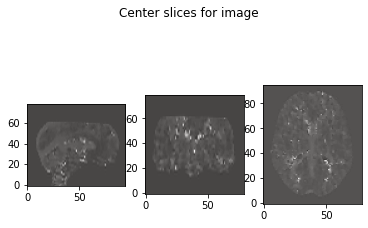

(79, 95, 79, 4)
(79, 95, 79, 1)
Image center:  39 47 39
Image center value:  5.7799997


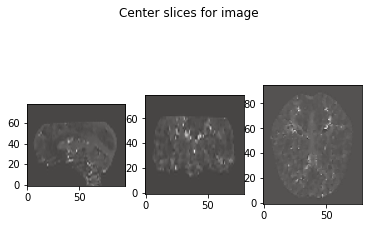

Image center:  39 47 39
Image center value:  93.1


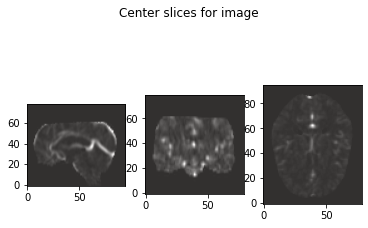

Image center:  39 47 39
Image center value:  8.51


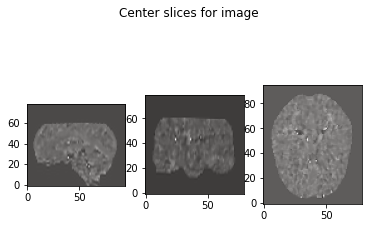

Image center:  39 47 39
Image center value:  12.67


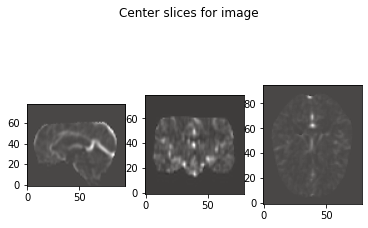

<module 'matplotlib.pyplot' from 'd:\\python\\anaconda3\\envs\\pctnet\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
flip_axis = (1)
random_flip_prob = 1
flip = RandomFlipTransform(axes=flip_axis, flip_probability=1, p=random_flip_prob, seed=seed, max_output_channels=max_output_channels)
print(images.numpy().shape)
print(labels.numpy().shape)
flipped_image, flipped_label = flip(images, labels)

display(images.numpy()[..., 0], mask=labels.numpy())

print(flipped_image.numpy().shape)
print(flipped_label.numpy().shape)
display(flipped_image.numpy()[..., 0], mask=flipped_label.numpy())
display(flipped_image.numpy()[..., 1], mask=flipped_label.numpy())
display(flipped_image.numpy()[..., 2], mask=flipped_label.numpy())
display(flipped_image.numpy()[..., 3], mask=flipped_label.numpy())

d:\python\anaconda3\envs\pctnet\lib\site-packages\torchio\transforms\augmentation\spatial\random_elastic_deformation.py:214: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [0, 1], so folding may occur. Choose fewer control points or a smaller maximum displacement
  warnings.warn(message, RuntimeWarning)


Image center:  39 47 39
Image center value:  5.7799998708069324


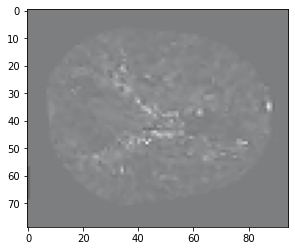

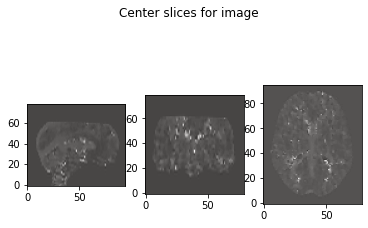

Image center:  39 47 39
Image center value:  3.4316156


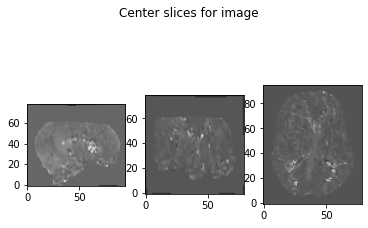

<module 'matplotlib.pyplot' from 'd:\\python\\anaconda3\\envs\\pctnet\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
elastic = RandomElasticTransform(max_displacement=[12, 12, 0],
                                   num_control_points=(7, 7, 7),
                                   image_interpolation='bspline',
                                   seed=seed, p=1,
                                   max_output_channels=max_output_channels, verbose=True)

elastic_image, elastic_label = elastic(images, labels)

plt.imshow(elastic_image.numpy()[..., 45, 0], cmap='gray')
plt.imshow(elastic_label.numpy()[..., 45, 0], cmap='Blues', alpha=0.4)

display(images.numpy()[..., 0], mask=labels.numpy())
display(elastic_image.numpy()[..., 0], mask=elastic_label.numpy())

Image center:  39 47 39
Image center value:  5.7799998708069324


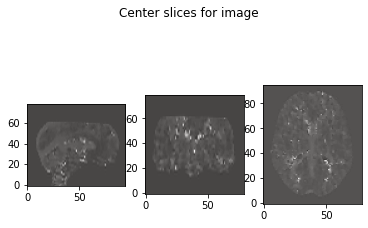

Image center:  39 47 39
Image center value:  13.522846


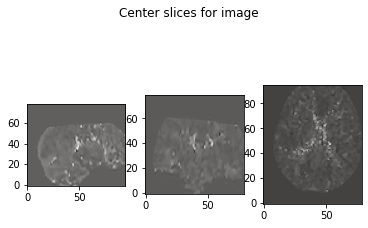

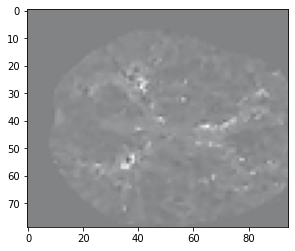

In [8]:
shift_val = (5, 5)  # translation range
rotate_val = (5, 5)  # rotation range
scale_val = (1.1, 1.1) # scaling range

affine = RandomAffineTransform(scales=scale_val, degrees=rotate_val, translation=shift_val,
                                  isotropic=True, default_pad_value=0,
                                  image_interpolation='bspline', seed=seed, p=1,
                                  max_output_channels=max_output_channels, verbose=True)

affine_image, affine_label = affine(images, labels)

display(images.numpy()[..., 0], mask=labels.numpy())
display(affine_image.numpy()[..., 0], mask=affine_label.numpy())
plt.imshow(affine_image.numpy()[..., 35, 0], cmap='gray')
plt.imshow(affine_label.numpy()[..., 35, 0], cmap='Blues', alpha=0.4)

Mean of input image: 7.534105429631702
Image center:  39 47 39
Image center value:  5.7799998708069324


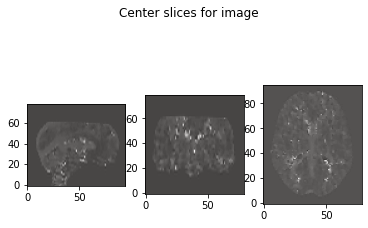

Image center:  39 47 39
Image center value:  11.985577


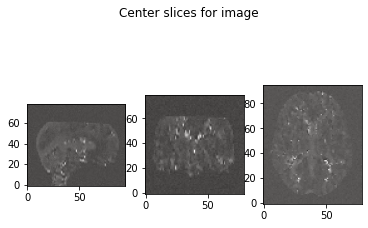

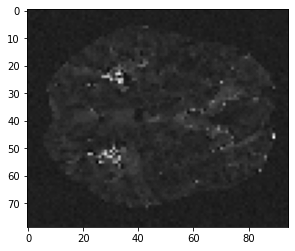

In [9]:
noise_mean = np.mean(raw_images[raw_mask]) # find appropriate mean by taking mean of masked image
print('Mean of input image:', noise_mean)
noise_std = (0.75, 0.75)  # range of noise std

noise = RandomNoiseTransform(mean=noise_mean, std=noise_std, seed=seed, p=1,
                                 max_output_channels=max_output_channels)

noise_image, noise_label = noise(images, labels)

display(images.numpy()[..., 0], mask=labels.numpy())
display(noise_image.numpy()[..., 0], mask=noise_label.numpy())
plt.imshow(noise_image.numpy()[..., 35, 0], cmap='gray')

In [10]:
# Check that the masks are the same at the output of the Noise function. (must be 0)
79*95*79 - torch.eq(labels, noise_label).sum()

tensor(0)

Image center:  39 47 39
Image center value:  5.7799998708069324


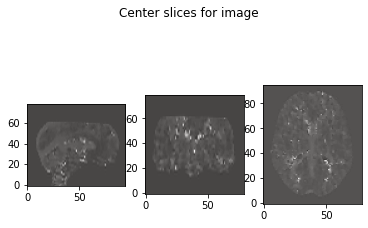

Image center:  39 47 39
Image center value:  2.075065336478872


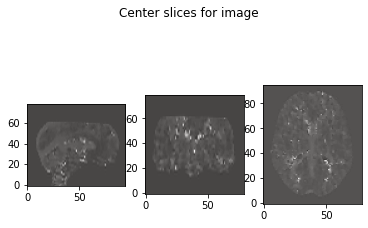

<module 'matplotlib.pyplot' from 'd:\\python\\anaconda3\\envs\\pctnet\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
from dataio.transformation.imageTransformations import StandardizeImage

norm = StandardizeImage(norm_flag=[True, True, True, False])


norm_image, norm_label = norm(images, labels)

display(images.numpy()[..., 0], mask=labels.numpy())
display(norm_image.numpy()[..., 0], mask=labels.numpy())

In [12]:
# Check that the masks are the same at the output of the NormalizeImage function. (must be 0)
79*95*79 - torch.eq(labels, norm_label).sum()

tensor(0)

In [28]:
print("Image Global Mean : \t\t", images.mean().item())
print("Standardized Global Mean : \t", norm_image.mean().item())

print("\nImage Global StD : \t\t", images.std().item())
print("Standardized Global StD : \t", norm_image.std().item())

print("\nChannel 0")
print("Channel 0 Mean : \t\t", images[..., 0].mean().item())
print("Standardized Channel 0 Mean : \t", norm_image[..., 0].mean().item())
print("Channel 0 StD : \t\t", images[..., 0].std().item())
print("Standardized Channel 0 StD : \t", norm_image[..., 0].std().item())

print("\nChannel 1")
print("Channel 1 Mean : \t\t", images[..., 1].mean().item())
print("Standardized Channel 1 Mean : \t", norm_image[..., 1].mean().item())
print("Channel 1 StD : \t\t", images[..., 1].std().item())
print("Standardized Channel 1 StD : \t", norm_image[..., 1].std().item())

print("\nAnd so on...")

Image Global Mean : 		 2.241366886711604
Standardized Global Mean : 	 2.1966729571658276e-15

Image Global StD : 		 7.312106323242159
Standardized Global StD : 	 0.9999993675012316

Channel 0
Channel 0 Mean : 		 0.9813577226908906
Standardized Channel 0 Mean : 	 -1.3917579892300362e-13
Channel 0 StD : 		 2.3125258100278248
Standardized Channel 0 StD : 	 0.9999999999967327

Channel 1
Channel 1 Mean : 		 5.241869842946057
Standardized Channel 1 Mean : 	 -2.3571896179464363e-13
Channel 1 StD : 		 13.354329748859866
Standardized Channel 1 StD : 	 1.0000000000002198

And so on...


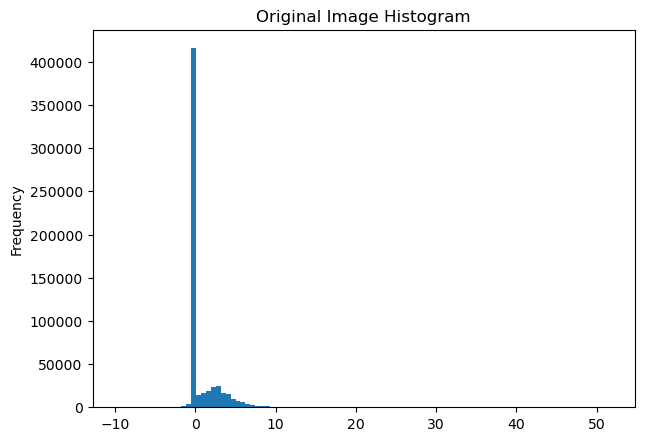

In [22]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on Initial Image
plt.hist(images[..., 0].numpy().flatten(), bins=100)
plt.gca().set(title='Original Image Histogram', ylabel='Frequency');

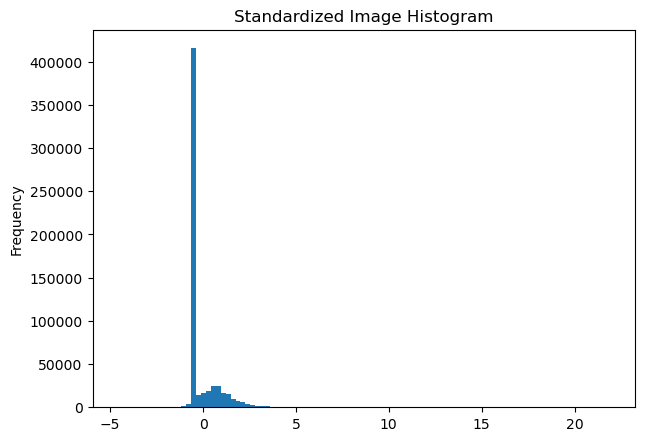

In [23]:
# Plot Histogram on Normalized Image
plt.hist(norm_image[..., 0].numpy().flatten(), bins=100)
plt.gca().set(title='Standardized Image Histogram', ylabel='Frequency');